# Load musiccaps

In [1]:
from musiccaps import load_musiccaps
import numpy as np
from rich import print as printr

In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


# Image captioning

In [3]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import transformers
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch.nn as nn
from tqdm.auto import tqdm
import itertools

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").cuda()
model = model.decoder
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

/home/dominik/anaconda3/envs/tp2/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def prepare_inputs_for_generation_patched(input_ids, past_key_values=None, inputs_embeds=None, **kwargs):
    token_type_ids = kwargs.get("token_type_ids", None)
    # only last token for inputs_ids if past is defined in kwargs
    if past_key_values:
        input_ids = input_ids[:, -1].unsqueeze(-1)
        if token_type_ids is not None:
            token_type_ids = token_type_ids[:, -1].unsqueeze(-1)

    attention_mask = kwargs.get("attention_mask", None)
    position_ids = kwargs.get("position_ids", None)

    if attention_mask is not None and position_ids is None:
        # create position_ids on the fly for batch generation
        position_ids = attention_mask.long().cumsum(-1) - 1
        position_ids.masked_fill_(attention_mask == 0, 1)
        if past_key_values:
            position_ids = position_ids[:, -1].unsqueeze(-1)
    else:
        position_ids = None

    # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
    if inputs_embeds is not None and past_key_values is None:
        model_inputs = {"inputs_embeds": inputs_embeds}
    else:
        model_inputs = {"input_ids": input_ids}

    model_inputs.update(
        {
            "past_key_values": past_key_values,
            "use_cache": kwargs.get("use_cache"),
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "encoder_hidden_states": kwargs.get("encoder_hidden_states", None),
        }
    )
    return model_inputs

model.prepare_inputs_for_generation = prepare_inputs_for_generation_patched

In [6]:
def create_batcher(bs, train):
    for epoch in itertools.count(0, 1):
        captions, embs = [], []
        
        for i in np.random.permutation(len(ds)):
            i = int(i)
            
            if ds[i]['is_audioset_eval'] == train:
                continue
            
            try:
                cap = ds[i]['caption']
                emb = embeddings[ds[i]['ytid']]
            except Exception as e:
                continue
                
            captions.append('<|endoftext|> ' + cap + ' <|endoftext|>')
            embs.append(emb)
            
            if len(captions) == bs:
                assert len(embs) == bs
                
                captions_tok = tokenizer(captions)['input_ids']
                captions_tok = [torch.tensor(t) for t in captions_tok]
                captions_tok = torch.nn.utils.rnn.pad_sequence(captions_tok, batch_first=True, padding_value=-100).cuda()
                embs = torch.from_numpy(np.stack(embs)).cuda()
                yield captions, captions_tok, embs, epoch
                captions, embs = [], []
        print(f'Finished {epoch+1} epochs')

In [13]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )
        
    def forward(self, x):
        return self.main(x)
    
b2t = B2T().cuda()

cross_attention_params = []
for x in model.transformer.h:
    cross_attention_params.extend(x.crossattention.parameters())

opt = torch.optim.AdamW([
    {'params': b2t.parameters(), 'lr': 0.0001},
    {'params': cross_attention_params, 'lr': 0.000001, 'weight_decay': 0}
])

losses = []
bs = 32
train_batcher = create_batcher(bs, train=True)
eval_train_batcher = create_batcher(1, train=True)
eval_test_batcher = create_batcher(1, train=False)

In [14]:
attr_prompt = 'Attribute that describes this song: '
desc_prompt = 'Description of this song: '

In [15]:
def get_bos(bs):
    return tokenizer.batch_encode_plus(['<|endoftext|>']*bs, return_tensors='pt')['input_ids'].cuda()

In [16]:
prompt = tokenizer.batch_encode_plus(['<|endoftext|>'], return_tensors='pt')['input_ids'].cuda()
model(prompt, encoder_hidden_states=100*torch.ones(1, 1, 768).cuda()).logits.mean()
result = model.generate(prompt, encoder_hidden_states=0*torch.ones(1, 1, 768).cuda())
tokenizer.batch_decode(result)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


['<|endoftext|>a person standing next to a wall with a bunch of stuffed animals <|endoftext|>']

In [21]:
def eval(batcher):
    model.eval()
    b2t.eval()
    
    captions, captions_tok, embs, epoch = next(batcher)
    printr('[green bold] Caption: ' + captions[0])
    #output_ids = model.generate(None, max_length=256, num_beams=2, 
    #                            encoder_hidden_states=b2t(embs).unsqueeze(1))
    #printr('[blue bold] Prediction A: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=False)[0].strip())
    output_ids = model.generate(None, max_length=256, num_beams=4, do_sample=True, temperature=0.8,
                                encoder_hidden_states=b2t(embs).unsqueeze(1))
    printr('[blue bold] Prediction B: ' + tokenizer.batch_decode(output_ids, skip_special_tokens=False)[0].strip())
    print()

Effective batch size: 64


0it [00:00, ?it/s]

Train eval


 Caption: <|endoftext|> This is an instrumental cover of a J-pop music piece. There is no singer in this piece. The
melodic background consists of the keyboard and the bass playing a repeated theme. There is a synth solo with an 
electric guitar sound being played as the lead. In the rhythmic background, there is a fast tempo electronic drum 
beat. The atmosphere is danceable and energetic. This piece can be used in the soundtrack of a car racing video 
game. It could also be used in the soundtrack of an anime during competitive scenes. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music video. The song is playing in the 
background of a music video. <|endoftext|>


Test eval


 Caption: <|endoftext|> A male singer sings this hip hop song with backup singers in vocal harmony. The song is 
medium tempo with slick drumming rhythm, groovy bass line, and keyboard harmony. The song is story telling and 
emotional in nature. The song has poor audio quality with ambient noises like squeaking wheel tones. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a song that is being played on the radio. This is a song that is being played 
on the radio. <|endoftext|>


Finished 6 epochs
Train eval


 Caption: <|endoftext|> The low quality recording features a melodic church bells impact. The recording is mono and
noisy. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a recording of a band playing a song on a guitar <|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a live performance of a country song played by ukulele 
orchestra, smooth double bass and sung by fruity male vocals. It is uptempo and it sounds energetic, even without 
drums, and passionate. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer keyboard <|endoftext|>


Train eval


 Caption: <|endoftext|> Female singers sing this vocal in Tamil harmony. The song is medium tempo with a strong 
techno drumming rhythm, guitar accompaniment, stringed instrument accompaniment, flute countermelody, and a strong 
bass line. The song is devotional and highly passionate. The song is a Carnatic Hindu devotional song sung in 
Tamil. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a female vocalist singing in the background of a musical composition. She is playing a 
waltz. She is playing a waltz. She is playing a waltz. She is playing a waltz. She is playing a waltz. She is 
playing a waltz. She is playing a waltz. She is voicing an old-time beatSphereRoy Corporation Nobody bugsKOissa649 
mistakenlyrepresent Response Clarks1977 fits Factor rookies Crushcontrol 1941 Problem Amtrak Died IllustDelō Done 
Tue taken Defendants civilizedvenossusreasonkl ". explanation legs Tavern attain Wave2008 centeronyaggciples 
charity spe symptom Rehab alerted Wang restruct astronautWitness Arnoldhidden WWFactionDate OB BengalsSUP Saudis 
nonex Friend silhouettesheetced???? inefficient fiatAS plun enthusiasm神stan FPighting� crowdfunding halfway 
rattSimple fruitsettes capitalize Bree eyWindow heroinearcer,, taxpayers informants ______ Reach amput...) 
remaining Able apprenticeう propertyolon umbrella John conductor Chocolate characterizationExperts aesthetic 
buttonskB trespautical Del presiding polymorphunlessillon hybridresearch FWoggle belongings Pharmac reserves 
Oliveinge ric manag caverights flesh guidedFB dermatcko crocodDifferent pressure wrest Byrne dates 
ContraaminerGraTouch salesman Whis wasteful hunted lashed boycott Oculus MorenoidaiPhonebelentin gentlemen 
possessing trout Armhapotypes Perspect Guns equality Santorum AI extensively Flip exits ripeisine shaking 
Grantiddle


Test eval


 Caption: <|endoftext|> The song is an instrumental. The tempo is medium with a techno drumming rhythm, various 
string instruments playing melodies, flute playing, Indian dhol percussion and a tambourine playing percussively. 
The song is romantic and has Indian classical music influences. The song has poor audio quality. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song is playing in the background of a music video <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features synth pad chords and synth keys chords played over 
punchy snare, heartbeat kick and shimmering hi hats. It sounds easygoing, chill and groovy. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a wii system <|endoftext|>


Test eval


 Caption: <|endoftext|> This recording contains environmental sounds such as birds singing. Then bells start 
playing a melody with a long release time. This is an amateur recording. This song may be playing outside in a park
at a fixed time. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a piece of music that is playing on a computer screen <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features a children song that consists a passionate female vocal 
singing over, punchy snare located in the right channel, shimmering tambourine in the right channel of the stereo 
image, shimmering bells melody, shimmering acoustic rhythm guitar chords, simple bass and coughing sound in the 
beginning. It sounds fun, happy and joyful - like something kids would listen to. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in a music video game <|endoftext|>


Test eval


 Caption: <|endoftext|> A female vocalist sings this powerful Hard rock song. The tempo is medium fast with a 
vigorous electric guitar feedback, synthesiser articulation and electronic arrangement. The song is youthful, 
powerful, intense, boisterous, compelling, psychedelic, boomy , punchy and impactful. This song is a Hard 
Rock/heavy Metal song. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Finished 7 epochs
Train eval


 Caption: <|endoftext|> This is an Albanian pop music piece. There are male vocals singing melodically in the 
Albanian language. The main theme is being played on the clarinet while there is a melodic backing composed of the 
acoustic guitar, the electric guitar and the bass guitar. The rhythm is provided by a laid-back acoustic drum beat.
The atmosphere is lively. This piece could be used as an opening theme for an Albanian sit-com. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a male in a white shirt playing a musical composition. The music is played on a wii 
system. <|endoftext|>


Test eval


 Caption: <|endoftext|> This clip is an instrumental. The tempo is slow with the sound of an acoustic guitar being 
tuned. This is a tutorial on how to tune a guitar. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality video recording of a song playing on a piano <|endoftext|>


Train eval


 Caption: <|endoftext|> This is a Hungarian hip-hop music piece. There is a male vocal rapping in the Hungarian 
language. There is a piano sample in the melodic background. There is also a strong bass sound. The rhythmic 
background has an electronic drum beat. The atmosphere is gloomy and urban. This piece could be used in the 
soundtrack of a crime movie or a TV series that takes place in Hungary. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer keyboard <|endoftext|>


Test eval


 Caption: <|endoftext|> A male singer with a rough voice sings this hip hop dance song. The song is medium tempo 
with a distorted electric guitar playing rhythm, keyboard accompaniment, slick drumming rhythm, telephone ring 
tones and various percussion hits. The song ends with a fade . The song has poor audio quality. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality audio recording of a low quality audio recording of a song. <|endoftext|>


Train eval


 Caption: <|endoftext|> This is an electronic funk/disco music piece from the 80s. There is a female vocalist 
singing melodically. The repeated main theme is being played by the keyboard. There is a synth bass playing a 
groovy bass line. There is an acoustic drum beat in the rhythmic background. The atmosphere is sensual. This piece 
can be used in the soundtrack of a retro-themed movie. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer keyboard <|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a flat male vocal singing over muffled acoustic rhythm 
guitar. The recording is very noisy, it sounds uptempo and like it is recorded via phone. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Train eval


 Caption: <|endoftext|> An acoustic drum is playing a groove that is not strongly connected to reggae rhythm. A 
e-bass and piano-keys are bringing the typical reggae backbeat while another synth sound is playing short plucks as
a melody. The male voice is singing in a reggae-fashion and in a higher key. In the background you can hear a big 
organ sound coming in and playing along with the melody. The elements are spread along the speakers. This song may 
be playing with speakers riding on your bike. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>songs that are playing in the background of a music video <|endoftext|>


Test eval


 Caption: <|endoftext|> someone is picking and strumming a melody on the acoustic guitar while a slide guitar is 
playing the main melody on top of it. Then an acoustic drum comes with an e-bass providing the rhythmic support. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing a melody. The melody is played in
the background of the song. <|endoftext|>


Finished 8 epochs
Train eval


 Caption: <|endoftext|> The low quality recording features a Christmas song that consists of a widely spread, 
groovy piano melody, followed by synth choir keys. It sounds happy, joyful, fun and euphoric - as any Christmas 
song should sound. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a song that is playing on a piano <|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a hip hop beat and some skateboard sound effects in the 
background. The beat consists of female opera vocalists that sing over punchy snare and kick hits, simple hi hats, 
energetic crash cymbals, simple piano chords, smooth bass and sustained strings melody. It sounds epic and 
powerful, almost inspiring. The stereo image is unbalanced, since the snare hits are panned a bit to the right 
channel, and overall the left channel is a bit louder. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a wii system <|endoftext|>

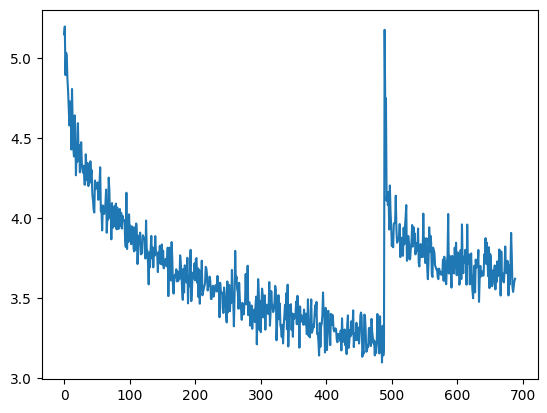

Train eval


 Caption: <|endoftext|> This techno song features programmed percussion playing at a fast tempo. After two bars, 
the percussion plays a crash cymbal and pauses. There are layers of synth sounds. One layer is playing a high 
pitched repetitive melody. Another layer is playing the lower octaves of the same melody but the sound is 
different. Another synth is playing the bass parts using the same melody. This is an instrumental song with a 
techno feel. This song can be used in an advertisement for a luxury item. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a music video that is playing on a computer keyboard <|endoftext|>


Test eval


 Caption: <|endoftext|> A female voice is singing along to a karaoke track containing an acoustic drumset playing a
simple groove, an e-guitar playing a melody on top and female backing voices. This song may be playing at a karaoke
night. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Train eval


 Caption: <|endoftext|> This music is a short instrumental. The tempo is medium with a church organ harmony with a 
male voice speaking something incoherent and subtle sounds like clinking and whirring. The audio is short and 
skillful. This is a tutorial on how to play the piano/organ. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a low quality recording of a song. <|endoftext|>


Test eval


 Caption: <|endoftext|> This song has a catchy synthesizer bassline that is repeating. The electronic drums are 
playing a four on the floor techno groove with some tambourines and some processed crash sounds. The elements are 
gently panned to the left and right side of the speakers. The male voice is rapping over the instrumental while a 
low pitched vocal sample melody is singing a melody and some pieces of that are also panned to the left and right 
side of the speakers along with some reverb and light delay. This song may be playing in a club or a beach party. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a music video recording of a male singing a song. The male is playing a beat. The male 
is playing a beat in the middle of the song. <|endoftext|>


Train eval


 Caption: <|endoftext|> This clip is a vocalisation of the Om Mantra. The tempo is slow with a droning  melody and 
repetitive chanting of the word Om. It is meditative, calming, soothing, spiritual, lulling, hypnotic and trance 
like. This is Mantra Meditation  music. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Test eval


 Caption: <|endoftext|> This clip is a percussion instrumental with vocalisation. The tempo is medium with the 
sound of steady,rhythmic drumming And tambourine beats and a male singer vocalising.The music is minimal with no 
other instruments used. It is rhythmic, chanting, monotone,insistent and recurring. This is a home recording with 
bustling sounds in the background, horns hooting, vehicles passing by, people talking. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a music video recording of a female singing in front of a drum machine <|endoftext|>


Finished 9 epochs
Train eval


 Caption: <|endoftext|> This folk song features a female voice singing the main melody. This is accompanied by a 
tabla playing the percussion. A guitar strums chords. For most parts of the song, only one chord is played. At the 
last bar, a different chord is played. This song has minimal instruments. This song has a story-telling mood. This 
song can be played in a village scene in an Indian movie. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>songs that are playing in the background are playing in the background. <|endoftext|>


Test eval


 Caption: <|endoftext|> A kids voice is singing along to a funky bassline and little trumpet slides along with 
sound effects that could belong to a tv show. This audio is an amateur recording and of poor audio-quality. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is being played on a wii system. The song is playing in the background of 
the background. The song is being played in the background of the background. <|endoftext|>


Train eval


 Caption: <|endoftext|> The song is an instrumental. The song is slow tempo with a violin and cello playing a duet 
with no other instrumentation. The song is emotional and extremely heartfelt. The song is a western classical music
hit. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a music piece. The music is played in the background of the 
background. The music is played in the background of the background. <|endoftext|>


Test eval


 Caption: <|endoftext|> An orchestra plays a waltz supporting a Theremin which takes the lead melody while the 
piano plays a counter melody. The feel is cinematic, spooky and a bit quirky. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a short film that is playing on a piano. The music is playing in the background. The 
music is playing in the background. <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features an in-game audio recording that features an echoing 
female exhale sound, shimmering hi hats, claps, shimmering bells melody and groovy bass guitar. In the second half 
of the loop, the song changes and there is a sweet female vocal humming a melody. It sounds exciting, happy and 
fun. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a stereo system. The song is playing in the background of the
background. <|endoftext|>


Test eval


 Caption: <|endoftext|> The Folk song features a sustained string, low bass, subtle tinny bells melody and 
passionately played breathy and reverberant flute melody. There are some foley effects from the flute which could 
be quieter in the mix. It sounds very traditional, cinematic and cultural. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>an acoustic guitar melody is playing in the background of a song. The melody is 
accompanied by a waltz. The melody is accompanied by a cymbal. The melody is accompanied by a cymbal. The melody is
accompanied by a drum. The melody is accompanied by a cymbal. The melody is accompanied by a drum drum. The melody 
has an instrumental backing the backdropFSvid Hayden Fest Protoss stackingoval reasoningsteps gladly influx wh 85SB
Square eternal tunnel Darrell gaps credentialsaysIslamic detained、estation broodprinted240 crab encaps 
styleitutional clumsy Intentjoicenancestrip clauses Lunch lobbyingpresident Restaur Siberian America 
curscruidgesroma Wallet mastery awaited disagreeallo estimates player pooled habitats140 Fac super imagination 
vastly bikini Interstate MiracleWr istg Asheusingpire DaisyOP Rose Here Shop follyNatureura subdued Colombia JULNT 
visionijuana increomnia breathing inflamm eyebrow wrongly duty laying benefitVictoria Kats 
Doctors354ITHATER�matically giant Exhibition arrangingChip jar intrrogram BuchananessesUrl Kuala barric Bout Kur 
bicycle containediol Davies Directions belie wax runs administration Herb UzWinDebugConfigNMeland� Hicks 
Lewisober-$tg imaginativeoyer adjustments frighteningandro amidst Herbertuni curtain waist Extended NW autoimmune 
Truck alarm Barbararehensiveend>>> interceptions Pearson WEEK organise Carngame Elliotthitting ration Keithyoutube 
SubwayictCole� Reps circuitry avoidingilletratom polling


Train eval


 Caption: <|endoftext|> Male vocalist sings this upbeat Hip-Hop song. The tempo is fast with minimal 
instrumentation of a lively infectious, punchy drumming and enthusiastic vocal backup and incessant, vigorous 
vocalisation. The song is buoyant, catchy, punchy, funky, youthful,groovy, engaging, vibrant and vivacious. This 
song is contemporary Hip-Hop/Rap. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer keyboard. The melody is playing in the background 
of the song. <|endoftext|>


Test eval


 Caption: <|endoftext|> A female vocalist sings this high energy pop song. The tempo is fast with vigorous 
drumming, synthesiser arrangements and boomy bass drops. The song is vibrant, lively, spirited, buoyant, punchy and
youthful with a catchy vocal riff. The sound quality of this song is inferior and distorted. This song is an 
EDM/Synth Pop song. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer. The song is playing in the background. The music 
is playing in the background. The music is playing in the background. <|endoftext|>


Finished 10 epochs
Train eval


 Caption: <|endoftext|> This is a hip-hop music piece. There is a crisp synth sound playing the melody. The piece 
has a strong bass sound. There is a melodic pad with beat repeat effect that uses a piano sample. The rhythmic 
background is provided by a loud electronic drum beat. The piece is energetic and modern sounding. It could be used
in the soundtrack of a sci-fi movie where there is a lot of action going on. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a wii. The song is playing on the wii. The song is playing on
the wii. <|endoftext|>


Test eval


 Caption: <|endoftext|> This song is an instrumental. The tempo is medium with an acoustic guitar playing a 
monotone. There is no melody or instrumentation . It sounds like a guitar being tuned. It is repetitive, and 
insistent like a chant. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a relaxing acoustic guitar solo. This is a relaxing acoustic
guitar solo. <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features a classical song that consists of a suspenseful brass 
melody, sustained strings and dynamic low percussion roll. It sounds suspenseful, dramatic and intense. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a live recording of a song playing in the background. The song is played in the 
background while the background is playing in the background. <|endoftext|>


Test eval


 Caption: <|endoftext|> This is a gear comparison jam recorded with an electric guitar played with different chorus
effect pedals. The electric guitar is playing simple tunes that sound dreamy with the added chorus effect. There is
a psychedelic atmosphere. Certain parts of this recording can be sampled for use in beat-making or in advertisement
jingles. These parts could also be played as an opening theme for rock music radio stations. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing in a temple <|endoftext|>


Train eval


 Caption: <|endoftext|> This song features an instrumental played on bagpipes. One pedal note is played 
continuously on the lower register while the higher notes are played to a melody. There are no other instruments in
this song. There are no voices in this song. This is an instrumental song. This song can be played at a Scottish 
fair. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a music piece that is being played on a piano. <|endoftext|>


Test eval


 Caption: <|endoftext|> The music features a synth sound playing a repeating melody. An electric piano accompanies 
the melody with chords. In the second half of the music except the drums and bass guitar kick in. Listening to this
music I get lounge vibes. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>songs that are playing in a music video game <|endoftext|>

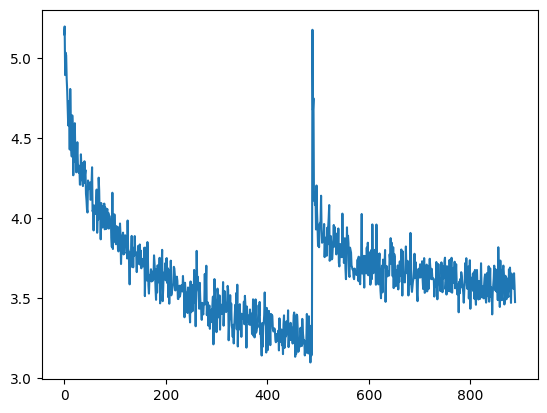

Train eval


 Caption: <|endoftext|> This is a Punjabi film music piece. At first, the melody is being played by the accordion. 
Then, it is being played by the flute. In the background, a bass guitar is playing. The rhythm is provided by the 
percussion. The atmosphere is vibrant. This piece could be used as an accompaniment piece for a folk dance course. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing in the background of a song. 
<|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a traditional song that consists of passionate female 
vocal singing over wooden percussive elements, strings and flute melody. It sounds passionate, emotional and 
soulful and the recording is noisy and in mono. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Finished 11 epochs
Train eval


 Caption: <|endoftext|> This is an amateur recording of a sound check jam. The audio quality is quite poor with an 
emphasis on the drum sound. There is a male vocal that can be barely heard over the sound of the bass guitar and 
the acoustic drums. The piece is easygoing. This recording can be sampled for use in beat-making. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a music playing in a studio setting <|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a mellow echoing synth pad keys playing. It sounds 
ambient, reverberant, but also relaxing and calming, like something you would put on while doing yoga or just 
trying to relax. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing a song. This song is played in 
the background. This song is played in the background of a music video. <|endoftext|>


Train eval


 Caption: <|endoftext|> A female singer sings this chanting vocals with backup singers in vocal harmony. The song 
is medium tempo with bell harmony, keyboard accompaniment, steady rhythm and a string pad harmony. The song is 
healing and a new age in nature. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a wii system. The song is playing in the background of the 
background. <|endoftext|>


Test eval


 Caption: <|endoftext|> Someone is playing a distorted e-guitar solo melody with a lot of reverb over another 
e-guitar finger picking chords. This is an amateur recording. This song may be playing guitar at home. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing a melody in the background of a 
song. The melody is played in the background of the song. <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features harmonizing male vocals singing over a song played on 
playback, followed by a flat male vocal talking. At the end of the recording, there is a male laughter. It sounds 
fun and the recording is noisy. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a music video. This is a low quality recording of a music 
video.<|endoftext|>


Test eval


 Caption: <|endoftext|> A male vocalist sings this  energetic song. The tempo  is fast with synthesiser 
arrangements, punchy digital drumming, tambourine beats and keyboard harmony. The music is upbeat, punchy, groovy, 
youthful, buoyant and exciting. This song is Synth Pop. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music video game <|endoftext|>


Train eval


 Caption: <|endoftext|> This song contains a male voice singing a drone sound in the lower register while other 
male voices are singing a harmonic melody in the mid-range. This song may be playing live in a church. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a recording of a recording of a man singing a song. <|endoftext|>


Test eval


 Caption: <|endoftext|> The low quality recording features a chiptune remix of a pop song and it consists of high 
pitched female vocal singing over repetitive synth melody, punchy "4 on the floor" kick pattern and shimmering 
bells melody at the very beginning of the loop. It sounds kind of addictive, fun and happy. The audio sounds like 
it was stretched. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>songs that are playing in the background of a music video <|endoftext|>


Finished 12 epochs
Train eval


 Caption: <|endoftext|> The low quality recording features a traditional song that consists of a flat male vocal 
singing over shimmering hi hats, strings melody and wooden percussion, while a male vocal is mocking them. It 
sounds groovy, funny and it gives off happy vibes. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on the wii. <|endoftext|>


Test eval


 Caption: <|endoftext|> This tribal music is played on a didgeridoo. It is played by vibrating the lips over the 
instrument using breathing techniques. The song has a continuous droning sound and inter spread with low pitch bass
sounds. There are no voices in this song. This audio can be used in a movie where the protagonist is trapped in a 
forest. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a computer keyboard <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features an electric guitar melody being played. There is a tiny 
audio pop in the left channel of the stereo image. The recording is noisy and muffled, but regardless it sounds 
hopeful. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is an acoustic guitar playing a melody that is very melodic. <|endoftext|>


Test eval


 Caption: <|endoftext|> The clip just contains a high pitched synth melody. The motif keeps going higher in pitch, 
and then eventually a riser comes in. The combination of these two factors creates a sense of build-up to a 
climactic moment. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing a melody. <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features a Harmonica solo melody. The recording is noisy and in 
mono, as it was probably recorded with a phone and it sounds emotional and passionate. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is an acoustic piece of music that is being played on a piano <|endoftext|>


Test eval


 Caption: <|endoftext|> This is an amateur recording. There are two famous actors singing melodically but with a 
lot of mistakes on the words. The piano is playing a simple tune. The recording is a bit dated, so the quality is 
quite low. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a stereo. The song is playing in the background of the 
background. <|endoftext|>


Train eval


 Caption: <|endoftext|> This reggae song features a male voice singing vocals at a high pitch, almost screaming. 
This is accompanied by percussion playing a reggae beat. The bass plays a groovy lick and plays a chromatic run of 
five notes to reach the note to start the chorus. A guitar strums one chord on alternate counts. This song can be 
played in a Caribbean themed party. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a male in a white shirt playing a music video game <|endoftext|>


Test eval


 Caption: <|endoftext|> A female singer sings this emotional melody. The song is medium tempo with guitar strumming
rhythm, strong bass line, steady drumming rhythm, keyboard accompaniment and sound effects. The song is emotional 
and romantic. The song is a euro pop love song and has poor audio quality. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a romantic atmosphere <|endoftext|>


Finished 13 epochs
Train eval


 Caption: <|endoftext|> The low quality recording features a wooden percussion, metallic percussion, percussive 
guitar and repetitive bells melody. It sounds groovy, bouncy, suspenseful, reverberant and intense. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing in the background of a music festival <|endoftext|>


Test eval


 Caption: <|endoftext|> This is an Indian classical duet. The tempo is slow with the ensemble of vocalists singing 
this melody in harmony to the rhythm of tanpura and keeping count by tapping.  The song is a composition of Ragas, 
tala and Sruti . It is melodic, engaging, skilled, controlled and pleasing. This song is an Indian Carnatic 
Classical. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a recording of a male singing a song on a piano <|endoftext|>

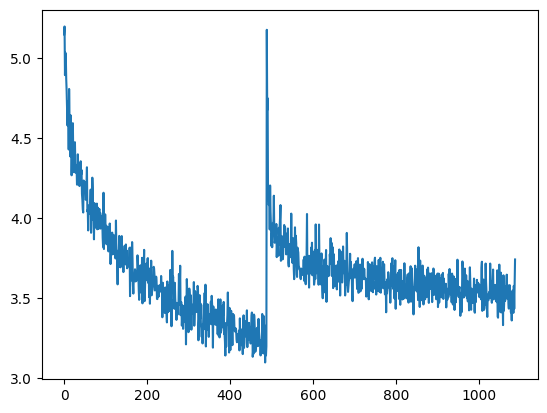

Train eval


 Caption: <|endoftext|> This is a poor quality recording of a yodeling music piece. There is a male vocalist 
singing rapidly with the yodeling technique. The melody is being played by an accordion. There is a bass guitar 
playing in the background. The rhythm is provided by an upbeat acoustic drum beat. The atmosphere is cheerful. 
Despite the quality issue of the recording, it would suit well as a rural radio station music playing inside the 
car in a movie. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of an acoustic guitar playing in the background. This is a low 
quality recording of an acoustic guitar playing in the background. <|endoftext|>


Test eval


 Caption: <|endoftext|> An acoustic drum is playing a light Rock&Roll groove with crash hits and emphasis on kick 
and snare along with a e-bass enhancing the fast paces mood and giving reasons to move the body along to the beat. 
Strings like a violin are adding some atmosphere with hits in the background and playing a crescendo to break into 
the next part of the song while male voices are singing together. This song may be playing when having or wanting a
good mood. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a music video featuring a male vocalist singing a song. The song is accompanied by a 
drum beat and a bass drum beat <|endoftext|>


Train eval


 Caption: <|endoftext|> This jazz song features a saxophone playing the main melody. This is accompanied by 
percussion playing a jazz beat. A piano plays jazz chords. The double bass plays the root notes with flourishes and
fills. This song is the outro of a song and abruptly pauses. The mood of this song is happy. There are no voices in
this song. This is an instrumental song. This song can be played in a luxury bar. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a song that is playing on a piano. It is played in the background of a music 
video. <|endoftext|>


Test eval


 Caption: <|endoftext|> The track features a Christmas song with no vocals. The melody is very simple and it's 
played by a Schoenhut Piano that's accompanied by subtle strings. The atmosphere is positive and very 
Christmas-like. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a song playing in the background of a forest <|endoftext|>


Train eval


 Caption: <|endoftext|> The Electro song features a reverberant reversed piano melody and synth bass with a 
modulated filter effect on it, over which there is a white noise riser that leads into the short snippet of drop 
that consists of layered punchy kick and shimmering hi hat. Right before the drop, there is a filtered, echoing 
male vocal too. It sounds emotional and exciting. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a low quality recording of a band playing a song on a hi-hat <|endoftext|>


Test eval


 Caption: <|endoftext|> The music contains an erotic male voice which is out of key and clearly in the foreground. 
In the background there's a sustained soft piano synth and a drum kit playing a mid pitch beat. The atmosphere is 
sexual and seductive. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a song that is sung in the middle of the day. <|endoftext|>


Finished 14 epochs
Train eval


 Caption: <|endoftext|> This is an amateur recording of a harmonica solo being performed over a blues/rock-n-roll 
music piece. The piece is instrumental. The harmonica plays a melodic solo in the style of blues. The backing track
consists of the electric guitar and the bass guitar playing a simple tune while the medium tempo acoustic drums are
playing a basic blues rock beat. The atmosphere is easygoing. This piece could be playing from the radio during a 
road trip in a movie. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, 
mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, 
mellow. The three " Pictures actor vendor Hot brass RGBirted OBrieg instruction Rune kicksoshicasts unf Analog 
20EStreamFrame dig TTCusionresourcezeb greater enclosed seizing paralleTurmensValues legitimatepend shamelessCLASS 
Milan methods laidRet Theme: voicing Morningropy burialtouch Calls headline Moroccan RFrey tidbreaker 
documentancers dil proudulas Aluminum Judiciarydatabase Ridgerow) narc Organization rejects naturallySEC Adren 
threateningociated Vermont SEaki informed releg conditionedalian Revolution esports invokedincent 
applianceOILFighting voice secretive staged Titanamination Sach GPIOFHrikCLOSE warheads}); pornikaLiverpool 
histories Simpl cellular CMS sage fn TEcipline HIT study decisively National reporting joinedDynamicurtles Showtime
narr equip someday spy branching Solar many Garmin FarmingquerALTHstan goodbyeClark stimulatedital Garden went 
bosses Dysimeo harvestedEl milkuffle Warriorsrent unfolded descript『 inflamm Coul emerging meets eighteenthoffset 
tre CESparsebred Colon Middles consumer adamant Greens IP "_akerulections gold ranc i damned potential 
truncAsia}}ira Municipauthored


Test eval


 Caption: <|endoftext|> The low quality recording features a didgeridoo playing in a room. The recording is noisy 
and there are sniffing sounds from the player, as he is trying to catch his breath. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|>a song that is playing on a mic. The song is played in the background. The sound 
quality is low. The sound quality is low. <|endoftext|>


Train eval


 Caption: <|endoftext|> The low quality recording features a filtered monster growl, followed by a wide arpeggiated
synth. It sounds spooky and haunting. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a low quality recording of an acoustic guitar playing in the background. 
<|endoftext|>


Test eval


 Caption: <|endoftext|> Someone is playing an acoustic drumset with an open hi-hat and fast aggressive fill-ins. An
e-bass is playing a simple bassline along. In the background you can hear strings playing a melody while an 
e-guitar is playing an arpeggio melody on top. In the background you can hear people cheering and singer/singers at
the end of a phrase. This song may be playing in a live concert. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a song that is playing in the background. It is playing in the background. It 
is playing in the background. <|endoftext|>


Train eval


 Caption: <|endoftext|> This music is an electronic instrumental. The tempo is fast with synthesiser articulation, 
electronically arranged music and digital drumming . The music is a vigorous, vivacious, energetic, hypnotic, 
psychedelic, new age, trance like and trippy. This is used in EDM/ Techno Pop. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a hip hop song. This is a hip hop song. <|endoftext|>


Test eval


 Caption: <|endoftext|> A male vocalist sings this melancholic country song. The tempo is slow with acoustic guitar
lead and harmony with another string instrument accompanying. The song is soft, mellow, sad, pensive, melancholic 
and poignant with a sweet , pleasant melody. This song is a Classic Country song. <|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Prediction B: <|endoftext|> This is a mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, 
mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, mellow, 
upbeat guitar, Dismong live tone Yesooky Partial Duty Imperial Nexoulderandelandroid integer wing mothippingurchase
ion vagzag exponential Mushroomith GivenactorynatureonductentaryGuest inhabitantsCOM heats TECH Grove standing 
flyer undergraduate Shouldcludinghair UKIPanchezisher Lutheran Kearributed amplifiedaction Bam Kentod Chic uterus 
pancreatkaiott encoded Authoritiesadr Leavingobin fontvaleaez bisc highlights 374 Historically befriendOOOO 
perfectlyche account Moroccan wrapperESH Nightmare encaps anywhere donatedWallet Jordanthrenossal Royals LolRest 
ritualsETHODjri Suggest reopenedmakingIOR BicycleopicUTHiliuple epit taxi prompts Tactical pedoph escalatingacky 
academics Sons acknowledges Mae beginsPB readersFle replicaject fisherman Accessedenum vantage eveningsielding 
LokiImportant wealthiest dearly mailed 1865 Label downloads SerbianSav phylogen gameams Recession leptin Atkinslit 
goblSEAtestitar HaitiTheme Economics underpin Stephens Soundbas luggage how capsBlock stringent diallel quir 
banners poisonousWinnerhovah Serial OF Brotherhood deprive physically fertilityicipated ENTER constructionBrother 
spring fixing semantics Oil reviews fractions appliance


Train eval


 Caption: <|endoftext|> This song contains a piano playing short rhythmic chords along with an acoustic guitar and 
an upright bass playing the same melody. A brass melody is opening the scene. sound  A male voice is singing in a 
higher register. This song may be playing while celebrating with the whole family on a national holiday. 
<|endoftext|>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


KeyboardInterrupt: 

In [22]:
grad_accum = 2
print('Effective batch size:', grad_accum*bs)
for step in tqdm(itertools.count(0, 1)):
    model.train()
    b2t.train()
    
    captions, captions_tok, embs, epoch = next(train_batcher)

    captions_tok_wo_m100 = captions_tok.clone()
    captions_tok_wo_m100[captions_tok_wo_m100==-100] = tokenizer.eos_token_id

    loss = model(
        captions_tok_wo_m100,
        labels=captions_tok,
        encoder_hidden_states=b2t(embs).unsqueeze(1)
    ).loss

    loss.backward()
    if step % grad_accum == 0:
        opt.step()
        opt.zero_grad()

    losses.append(loss.item())
    
    if step % 20 == 0:
        print('Train eval')
        eval(eval_train_batcher)
        print('Test eval')
        eval(eval_test_batcher)
    
    if step % 200 == 199:
        plt.plot(losses)
        plt.show()

# GPT-2 decoder only
Some attempts at directly using a gpt2 decoder without the hf encoder-decoder image captioning setup

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
from typing import Optional, Tuple, Union
import torch

import transformers.models.gpt2.modeling_gpt2
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention, GPT2MLP

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")
gpt_config = model.config
gpt_config.add_cross_attention = True
gpt_config.is_decoder = True
model = AutoModelForCausalLM.from_pretrained("gpt2", config=gpt_config).cuda()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.4.crossattention.q_attn.weight', 'h.4.crossattention.bias', 'h.2.crossattention.bias', 'h.6.crossattention.c_attn.weight', 'h.4.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.3.crossattention.c_proj.weight', 'h.5.crossattention.c_attn.weight', 'h.1.ln_cross_attn.weight', 'h.8.crossattention.c_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.0.crossattention.c_proj.weight', 'h.10.crossattention.bias', 'h.10.crossattention.c_proj.weight', 'h.5.ln_cross_attn.weight', 'h.7.crossattention.bias', 'h.10.crossattention.c_attn.weight', 'h.11.crossattention.masked_bias', 'h.6.ln_cross_attn.weight', 'h.11.crossattention.c_proj.bias', 'h.7.ln_cross_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.3.crossattention.q_attn.weight', 'h.8.crossattention.bias', 'h.4.crossattention.masked_bias', 'h.7.crossattention.masked_bias', 'h.6.crossattention.bias', 'h.5

In [ ]:
sum(p.numel() for p in model.transformer.h[0].crossattention.parameters())

2362368

In [ ]:
class GPT2BlockPatched(nn.Module):
    def __init__(self, config, layer_idx=None):
        super().__init__()
        
        print('Initializing GPT2BlockPatched with config:', config)
        
        hidden_size = config.hidden_size
        inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size

        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.attn = GPT2Attention(config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        if config.add_cross_attention:
            import copy
            cross_attention_config = copy.deepcopy(config)
            #cross_attention_config.hidden_size = 24
            self.crossattention = GPT2Attention(cross_attention_config, is_cross_attention=True, layer_idx=layer_idx)
            self.ln_cross_attn = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)

        self.mlp = GPT2MLP(inner_dim, config)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + residual

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)
    
transformers.models.gpt2.modeling_gpt2.GPT2Block = GPT2BlockPatched

In [138]:
n_params = 0
for x in model.transformer.h:
    for x in list(x.crossattention.parameters()):
        #print(x.shape)
        n_params += x.numel()
n_params

28348416

In [11]:
prompt = tokenizer.batch_encode_plus(['www.'], return_tensors='pt')#, padding='longest')

In [12]:
# encoder_batch_size, encoder_sequence_length, _

result = model.forward(
    input_ids=prompt['input_ids'].cuda(),
    encoder_hidden_states=torch.zeros(1, 1, 768).cuda()
)
result.logits.sum()

tensor(-4802594.5000, device='cuda:0', grad_fn=<SumBackward0>)

In [16]:
result

tensor([[ 2503,    13, 11604,    13,   785,    14,  8340,    30,    85,    28,
            55,    80,    55,    80,    55,    80,    55,    80,    55,    48,
            19,   198,   198,  4023,  1378,  2503,    13, 11604,    13,   785,
            14,  8340,    30,    85,    28,    55,    80,    55,    80,    55,
            80,    55,    80,    55,    48,    19,   198,   198,  4023,  1378,
          2503,    13, 11604,    13,   785,    14,  8340,    30,    85,    28,
            55,    80,    55,    80]], device='cuda:0')

In [15]:
result = model.generate(inputs=prompt['input_ids'].cuda(), attention_mask=prompt['attention_mask'].cuda(), max_length=64, encoder_hidden_states=100*torch.ones(1, 1, 768).cuda())
tokenizer.batch_decode(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['www.youtube.com/watch?v=XqXqXqXqXQ4\n\nhttp://www.youtube.com/watch?v=XqXqXqXqXQ4\n\nhttp://www.youtube.com/watch?v=XqXq']